## Time series analysis of flood tags data - FSD-1777

In [1]:
!pip install python-dotenv

In [1]:
import sys
sys.path.append('G:\My Drive\LLM-repo1\data_source')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import sys
import shapely
import dotenv
from datetime import datetime
import pandas as pd
import json
import floodtags_API
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# Scenario 1 - (Warning) Get data from flood tags API  

In [ ]:
#Bounding box of the area of interest - FSD-1777,UK and Scotland 19 to 23 Oct 2023
geometry = [[134.828733,35.425495],[138.827937,35.425495],[138.827937,33.4054],[134.828733,33.4054],[134.828733,35.425495]]
a = shapely.Polygon(geometry)
bbox = list(shapely.bounds(a))
print(bbox)


[134.828733, 33.4054, 138.827937, 35.425495]


[134.828733, 33.4054, 138.827937, 35.425495]


In [4]:
start_date  = datetime(2023, 5, 20, 0, 0, 0)
end_date = datetime(2023, 6, 2, 8, 0, 0)
sources = ["japanese-flood"]

# flood_classes = ["class:flood-logistics",
#                  "class:flood-affected"]

response_dict = floodtags_API.analyze_watersheds(start_date=start_date,
                                  end_date=end_date,
                                  sources= sources,
                                  bbox= bbox)

In [5]:
start_date  = datetime(2023, 6, 2, 8, 0, 1)
end_date = datetime(2023, 6, 3, 22, 0, 0)
sources = ["japanese-flood"]

# flood_classes = ["class:flood-logistics",
#                  "class:flood-affected"]

response_dict2 = floodtags_API.analyze_watersheds(start_date=start_date,
                                  end_date=end_date,
                                  sources= sources,
                                  bbox= bbox)

In [7]:
start_date  = datetime(2023, 6, 3, 22, 0, 1)
end_date = datetime(2023, 6, 8, 23, 59, 59)
sources = ["japanese-flood"]

# flood_classes = ["class:flood-logistics",
#                  "class:flood-affected"]

response_dict3 = floodtags_API.analyze_watersheds(start_date=start_date,
                                  end_date=end_date,
                                  sources= sources,
                                  bbox= bbox)

Since flood tags can only handle only 10000 pragnators we combine data since it excceeds the 10k mark

In [8]:
response_dict.extend(response_dict2)


In [9]:
response_dict.extend(response_dict3)

In [10]:
# #Save response as json
with open("G:\My Drive\LLM-repo1\data_source\FSD1555_June23.json", "w") as fp:
    print("Done writing dict into .json file")
    json.dump(response_dict, fp)  # encode dict into JSON
print("Done writing dict into .json file")

Done writing dict into .json file
Done writing dict into .json file


## Scenairo 2 - Load the data from saved json

In [3]:
with open("G:\My Drive\LLM-repo1\data_source\FSD1555_June23.json", 'r') as json_file:
    response_dict = json.load(json_file)

In [4]:
df = pd.DataFrame(response_dict)

In [5]:
df[df['id']=="t-1664659144715149313"]

,id,date,text,tag_class,source,lang,urls,locations
13921,t-1664659144715149313,2023-06-02T15:44:02.000Z,天竜川氾濫したら浜松終わるぞ\nまじで言ってる？,None,twitter,ja,https://twitter.com/Ceres_i/status/16646591447...,"[{'type': 'Feature', 'geometry': {'type': 'Poi..."
13922,t-1664659144715149313,2023-06-02T15:44:02.000Z,天竜川氾濫したら浜松終わるぞ\nまじで言ってる？,None,twitter,ja,https://twitter.com/Ceres_i/status/16646591447...,"[{'type': 'Feature', 'geometry': {'type': 'Poi..."


In [6]:
#Remove the duplicate entry
x=df.drop(13922)

In [7]:
df = x

Ensure no duplicates exist

In [8]:
duplicate_tags = df[df.duplicated('id')]
print(duplicate_tags)

Empty DataFrame
Columns: [id, date, text, tag_class, source, lang, urls, locations]
Index: []


Specify date time column for time series analysis

In [9]:
#Index 8862 does not have dateime in the correct format so we remove
df.iloc[8862]
df = df.drop(8862)

In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
#Drop columns that are not needed for analysis
df = df.drop(['text', 'source', 'lang', 'urls','locations'],axis =1)

In [14]:
# Find the minimum and maximum dates
min_date = df['date'].min()
max_date = df['date'].max()
print(min_date, "__" ,max_date)

2023-05-20 00:07:31+00:00 __ 2023-06-08 23:57:26+00:00


Create count mechanism from the date time only and resample to have buckets of time series data

In [12]:
df_count = df[['date']].copy()

In [13]:
# Create a count column with constant value 1
df_count['count'] = df.apply(lambda x: 1, axis=1)

In [15]:
# Set the 'datetime' column as the index
df_count.set_index('date', inplace=True)

Sample counts of tweets by the hour

In [16]:
# Resample the data to hourly frequency and sum the counts
hourly_data = df_count.resample('H').sum()
hourly_data = hourly_data.asfreq('h')

Function from [Do more with Twitter](https://https://twitterdev.github.io/do_more_with_twitter_data/timeseries.html)


In [17]:
def plot_ts(series,
            ma=False,
            raw=False,
            expanding=False,
            ewma=False,
            overall=False,
            median=False,
            title=None,
            time_bin="hour",
            date_markers=None,
            y_label=None,
            custom_yaxis=None,
            custom_ax=None,
            **kwargs):
    """
    custom plotting function for our time-series dataframes.

    Args:
        series: pd.Series or pd.Dataframe
        raw: plot the basic values in the frame
        expanding: plot an expanding mean
        ewma: plot an ewma line
        overall: plot an overall mean
        median: plot the overall median
        title: custom title to use
        time_bin: marks the y-axis correctly
        date_markers: plots a dot on the signal where a given date is noted.
        y_label: custom y-axis label
        custom_yaxis: custom axis
        custom_ax: passing a custom Axes here will assign this plot to that
                   axis


   """
    if isinstance(series, pd.DataFrame):
        series = series["count"]

    lw = 0.75
    if custom_ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        ax = custom_ax

    if y_label is None:
        period = series.index.to_period().freqstr
        _bin = "day" if period == "D" else "hour"
        _y_label = "tweets per {}".format(_bin)
        plt.ylabel(_y_label)
    else:
        if isinstance(y_label, str):
            plt.ylabel(y_label)

    if date_markers is not None:
        def dateindex_to_str(index, include_hour=True):
            idx = 16 if include_hour else 10
            return [str(date)[0:idx].replace("T", " ")
                    for date in index.values]

        (ax.plot(date_markers, series.loc[date_markers],
                 "o", markersize=4, color='m', label="point"))

    if raw:
        series.plot(label="raw", lw=lw, ax=ax)

    if ma:
        (series.rolling(ma).mean()
         .plot(ax=ax, label="{}{} ma".format(ma, time_bin), lw=lw))

    if ewma:
        if isinstance(ewma, int):
            (series.ewm(span=ewma).mean()
             .plot(ax=ax, label="emwa - span {}".format(ewma), lw=lw))
        else:
            (series.ewm(alpha=0.05).mean()
             .plot(ax=ax, label="emwa, $\alpha = 0.05$", lw=lw))

    if expanding:
        series.expanding().mean().plot(ax=ax, label="expanding_mean", lw=lw)

    if overall:
        (pd.DataFrame(series)
         .assign(global_mean=lambda x: x['count']
                 .mean())["global_mean"]
         .plot(ax=ax, label="global_mean", lw=lw))

    if median:
        (pd.DataFrame(series)
         .assign(global_median=lambda x: x['count'].median())["global_median"]
         .plot(ax=ax, label="global_median"))

    plt.tight_layout()
    plt.xlabel("date")

    if custom_yaxis is not None:
        def log_axis(x, pos):
            'The two args are the value and tick position'
            str_ = '$' + "2^{" + str(x) + "}" + '$'
            return str_
        formatter = FuncFormatter(log_axis)
        ax.yaxis.set_major_formatter(formatter)

    if title:
        ax.set_title(title)
    if custom_ax is not None:
        #Save to file
        plt.savefig("FSD1555_hourlytweetcount", bbox_inches='tight')
        return
    else:
        #Save to file
        plt.savefig("FSD1555_hourlytweetcount", bbox_inches='tight')
        return ax

def make_normalplot(df, random=True):
    if random:
        plt.plot(df.index.values,
                 np.random.normal(size=df.shape[0]),
                 lw=0.8,
                 alpha=0.75)
        plt.ylim((-5, 5))
        plt.title("Generated normal time series with $\sigma$ bands")
    else:
        plt.plot(df.index.values, df.values, lw=0.8, alpha=0.75)
        plt.ylim((-5, 8))
        plt.title("Dataframe with bands showing up to 3 sigma")

    plt.axhline(y=1, color="red")
    plt.axhline(y=-1, color="red")
    plt.axhline(y=2, color="orange")
    plt.axhline(y=-2, color="orange")
    plt.axhline(y=3, color="yellow")
    plt.axhline(y=-3, color="yellow")

    arrowprops = dict(arrowstyle="-",
                      color="black",
                      lw=2)

    #textprops = dict(rotation="vertical", fontsize=16)
    # textprops = dict()

    # plt.annotate("1 $\sigma$",
    #              xy=(df.index.values[10], 1),
    #              xytext=(df.index.values[10], -1.5),
    #              arrowprops=arrowprops,
    #              **textprops)

    # plt.annotate("2 $\sigma$",
    #              xy=(df.index.values[750], 2),
    #              xytext=(df.index.values[750], -2.5),
    #              arrowprops=arrowprops,
    #              **textprops
    #              )

    # plt.annotate("3 $\sigma$",
    #              xy=(df.index.values[1500], 3),
    #              xytext=(df.index.values[1500], -3.5),
    #              arrowprops=arrowprops,
    #              **textprops
    #              )

def standardize(df):
  """
  Put the data in the dataframe in units of deviation from the mean.
  """
  return (df - df.mean()) / df.std()

def median_abs_dev(df, constant=None):
    if constant is None:
        # allows us to use the MAD to roughly approximate to the standard deviation
        # see the wikipedia page
        constant = 1.4826
    # rolling will take numpy arrays
    abs_dev = constant * np.median(np.abs((df - np.median(df))))
    return abs_dev


def mad_normalize(df, constant=None):
    # puts this dataframe into multiples of the MAD, similar to Zscoring
    # abs(x - median(x)) / MAD(df)
    return (df
             .sub(np.median(df))
             .pipe(np.abs)
             .div(median_abs_dev(df)))

C:\Users\mbhatti\AppData\Local\Temp\ipykernel_16520\2496361491.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  period = series.index.to_period().freqstr


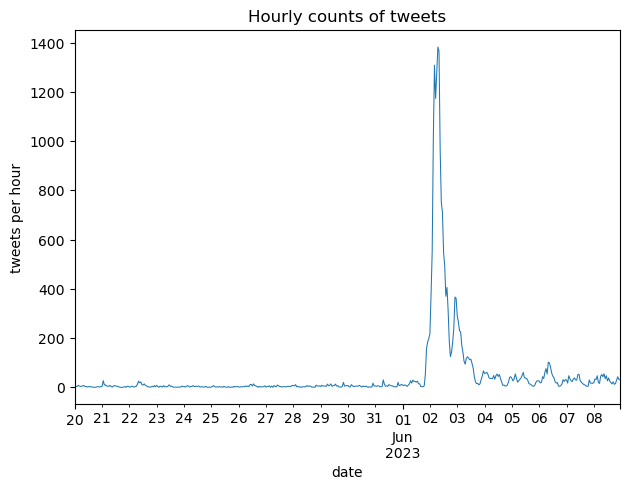

In [18]:
plot_ts(hourly_data, raw=True, title="Hourly counts of tweets");

Hourly bin summary

In [19]:
print(hourly_data.describe().drop("count", axis=0))

            count
mean    48.575000
std    164.510594
min      0.000000
25%      3.000000
50%      6.000000
75%     26.250000
max   1383.000000


In [20]:
#Check for 0 values
subset_boolean = hourly_data[hourly_data['count'] == 0]
subset_boolean

,count
date,
2023-05-20 17:00:00+00:00,0
2023-05-20 18:00:00+00:00,0
2023-05-21 16:00:00+00:00,0
2023-05-21 17:00:00+00:00,0
2023-05-21 18:00:00+00:00,0
2023-05-21 21:00:00+00:00,0
2023-05-23 02:00:00+00:00,0
2023-05-23 15:00:00+00:00,0
2023-05-23 18:00:00+00:00,0


In [21]:
#Start dataset after the date we have no zero values in
threshold_datetime_greater = pd.to_datetime('2023-05-30 18:00:01+00:00')

#Threshold to stop
threshold_datetime_less = pd.to_datetime('2023-06-09 00:00:00+00:00')

hourly_data = hourly_data[hourly_data.index > threshold_datetime_greater]
hourly_data = hourly_data[hourly_data.index < threshold_datetime_less]

In [22]:
hourly_data

,count
date,
2023-05-30 19:00:00+00:00,2
2023-05-30 20:00:00+00:00,1
2023-05-30 21:00:00+00:00,1
2023-05-30 22:00:00+00:00,17
2023-05-30 23:00:00+00:00,5
...,...
2023-06-08 19:00:00+00:00,15
2023-06-08 20:00:00+00:00,29
2023-06-08 21:00:00+00:00,43


Histogram and log transformed histogram

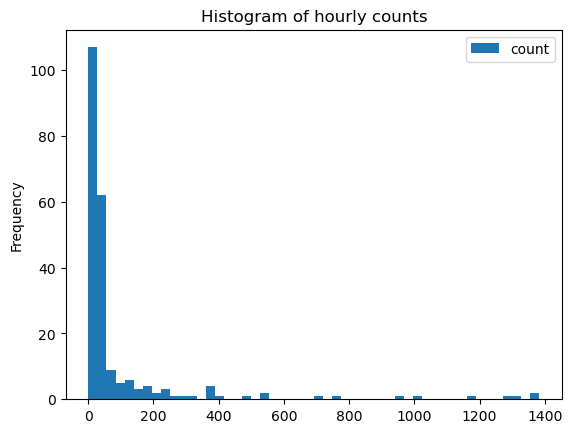

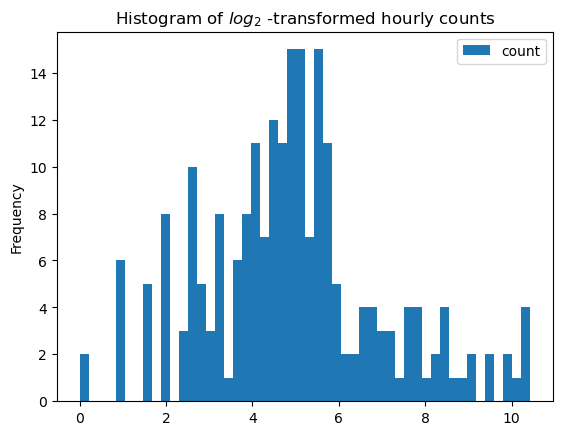

In [60]:
hourly_data.plot.hist(bins=50, title="Histogram of hourly counts");
np.log2(hourly_data).plot.hist(bins=50,
                      title="Histogram of $log_2$ -transformed hourly counts");

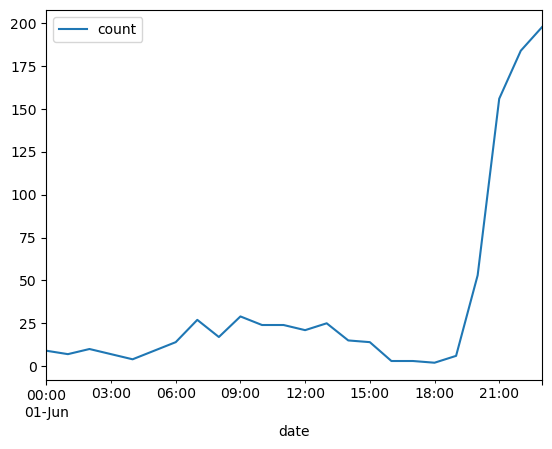

In [27]:
hourly_data["2023-06-01":"2023-06-01"].plot(kind="line")

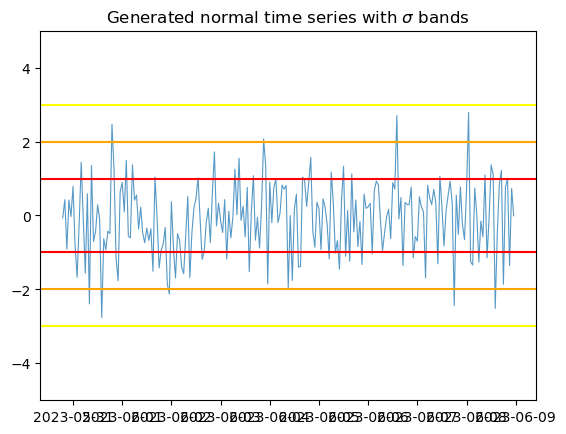

In [30]:
make_normalplot(hourly_data, random=True)

Log2 transformed data

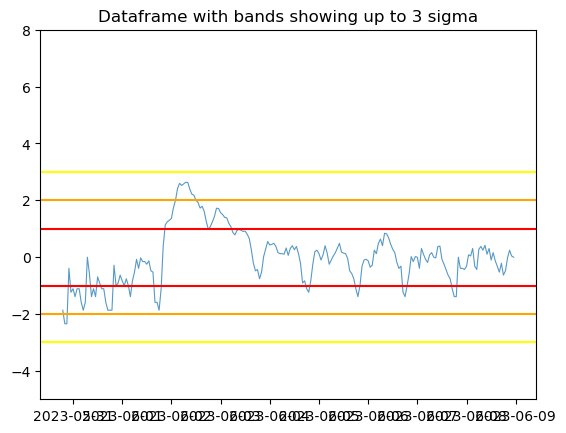

In [64]:
(hourly_data
 .pipe(np.log)
 .pipe(standardize)
 .pipe(make_normalplot, random=False))

After plotting the normal and log transformed data it can be seen that the data does not exceed 3 standard devations at the peak of tweets per hour. Possibilty of data exceeding the 3 standard deviation mark may exist with a longer window of time before and after the main flooding days

# Median Absolute deviance

In [65]:
print("median abs deviation of total sample: {}".format(hourly_data.pipe(median_abs_dev)))

median abs deviation of total sample: 29.651999999999997


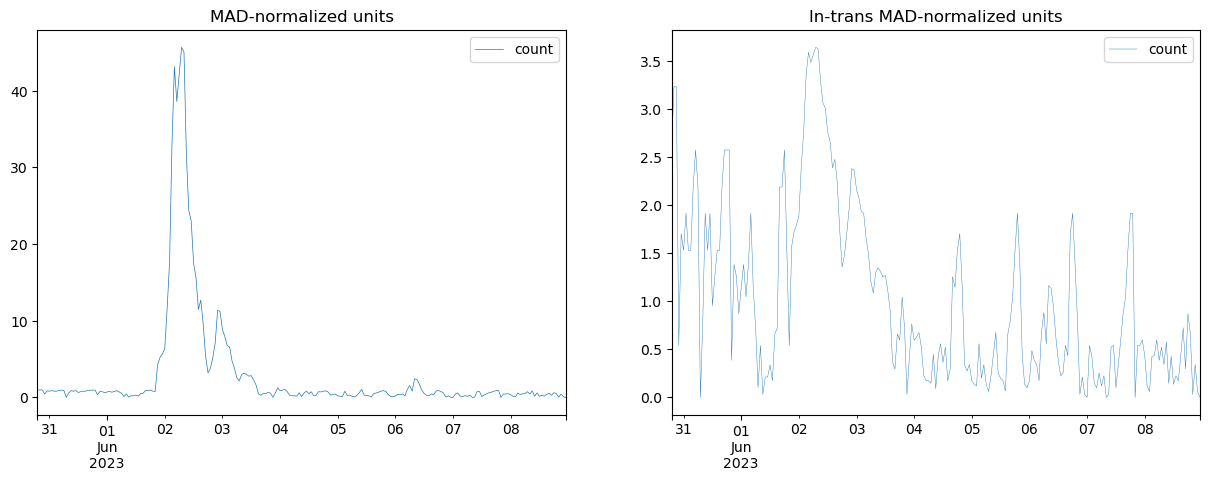

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
[ax.xaxis.label.set_visible(False) for ax in axes.ravel()]
(hourly_data
 .pipe(mad_normalize)
 .plot(ax=axes[0],
      lw=0.5,
       title="MAD-normalized units"));
(hourly_data
 .pipe(np.log)
 .pipe(mad_normalize)
 .plot(ax=axes[1],
       lw=0.3,
       title="ln-trans MAD-normalized units"));

# Differencing methods


Simple differncing

            count
count  220.000000
mean     0.127273
std     58.493587
min   -397.000000
25%    -10.000000
50%     -1.000000
75%      7.000000
max    458.000000


C:\Users\mbhatti\AppData\Local\Temp\ipykernel_23492\2651109063.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  period = series.index.to_period().freqstr


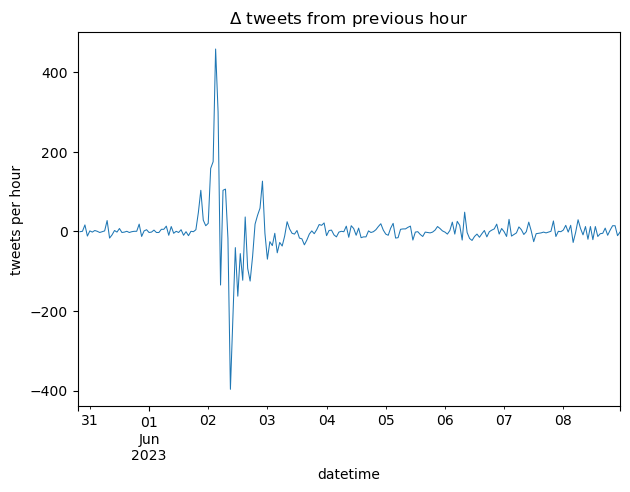

In [67]:
print(hourly_data.diff().describe())
(hourly_data
 .diff()
 .pipe(plot_ts,  raw=True,
       title="$\Delta$ tweets from previous hour")
);

Percentage changed

C:\Users\mbhatti\AppData\Local\Temp\ipykernel_23492\2651109063.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  period = series.index.to_period().freqstr


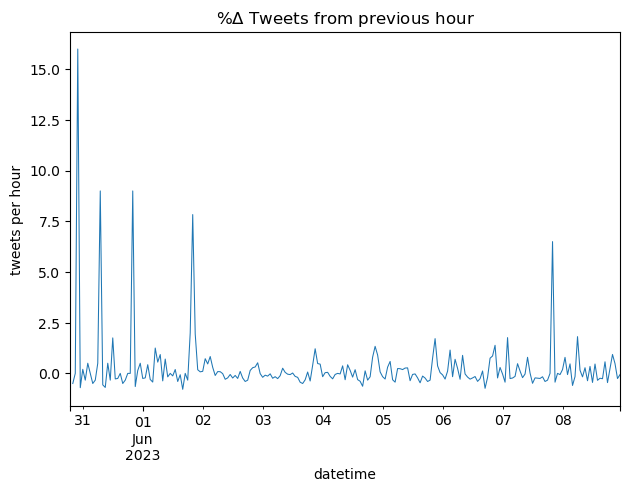

In [68]:
plot_ts(hourly_data.pct_change(),
        raw=True,
        title="%$\Delta$ Tweets from previous hour");

# Moving/ Rolling statistics

Trend of daily tweet count

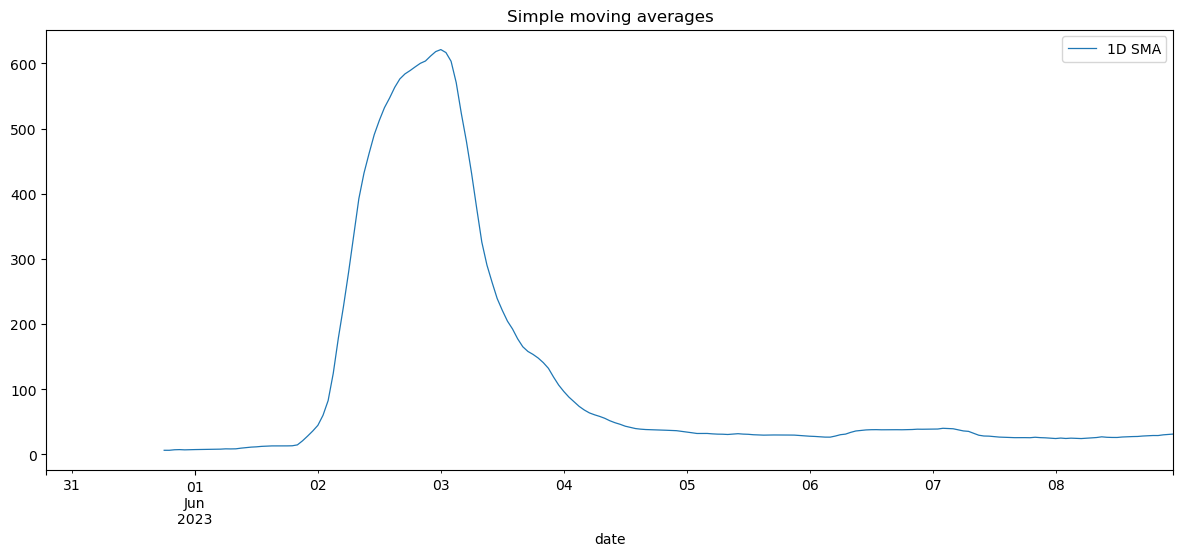

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (12, 5))
fig.tight_layout()
hourly_data.rolling(24).mean().rename(columns={"count": "1D SMA"}).plot(ax=axes, lw=0.9);
axes.set_title(label="Simple moving averages");

# Detrending time series

In [70]:
def detrender(df, periods=None, method=None):
    periods = 24 if periods is None else periods
    func = np.mean if method is None else method

    return df - df.rolling(periods).apply(func)

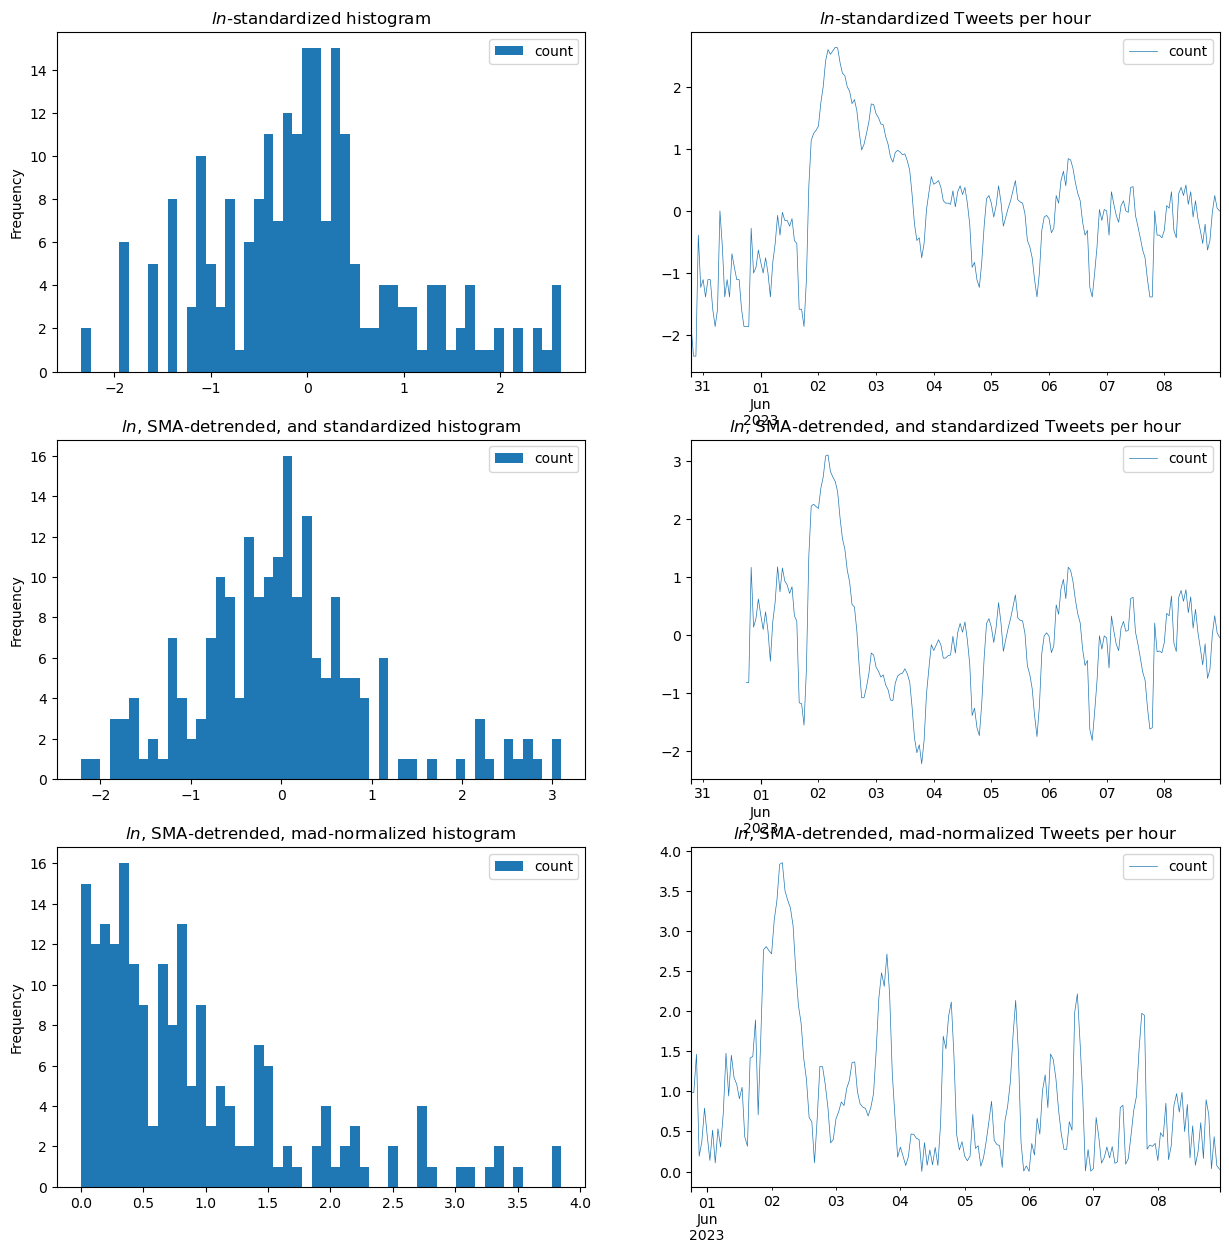

In [71]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (15, 15))
[ax.xaxis.label.set_visible(False) for ax in axes.ravel()]

(hourly_data
 .pipe(np.log)
 .pipe(standardize)
 .plot
 .hist(bins=50,
       title="$ln$-standardized histogram",
       ax=axes[0][0]) );

(hourly_data
 .pipe(np.log)
 .pipe(standardize)
 .plot(ax=axes[0][1],
       lw=0.5,
       title="$ln$-standardized Tweets per hour"));


(hourly_data
 .pipe(np.log)
 .pipe(detrender)
 .pipe(standardize)
 .plot
 .hist(bins=50,
       title="$ln$, SMA-detrended, and standardized histogram",
       ax=axes[1][0]) );

(hourly_data
 .pipe(np.log)
 .pipe(detrender)
 .pipe(standardize)
 .plot(ax=axes[1][1],
       lw=0.5,
       title="$ln$, SMA-detrended, and standardized Tweets per hour"));

(hourly_data
 .pipe(np.log)
 .pipe(detrender)
 .dropna()
 .pipe(mad_normalize)
 .plot.hist(ax=axes[2][0], bins=50,
       #lw=0.5,
       title="$ln$, SMA-detrended, mad-normalized histogram"));
(hourly_data
 .pipe(np.log)
 .pipe(detrender)
 .dropna()
 .pipe(mad_normalize)
 .plot(ax=axes[2][1],
       lw=0.5,
       title="$ln$, SMA-detrended, mad-normalized Tweets per hour"));

Spikes detectors using above mentioned methods

C:\Users\mbhatti\AppData\Local\Temp\ipykernel_23492\2651109063.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  period = series.index.to_period().freqstr
C:\Users\mbhatti\AppData\Local\Temp\ipykernel_23492\2651109063.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  period = series.index.to_period().freqstr
C:\Users\mbhatti\AppData\Local\Temp\ipykernel_23492\2651109063.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  period = series.index.to_period().freqstr
C:\Users\mbhatti\AppData\Local\Temp\ipykernel_23492\2651109063.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  period = series.index.to_period().freqstr


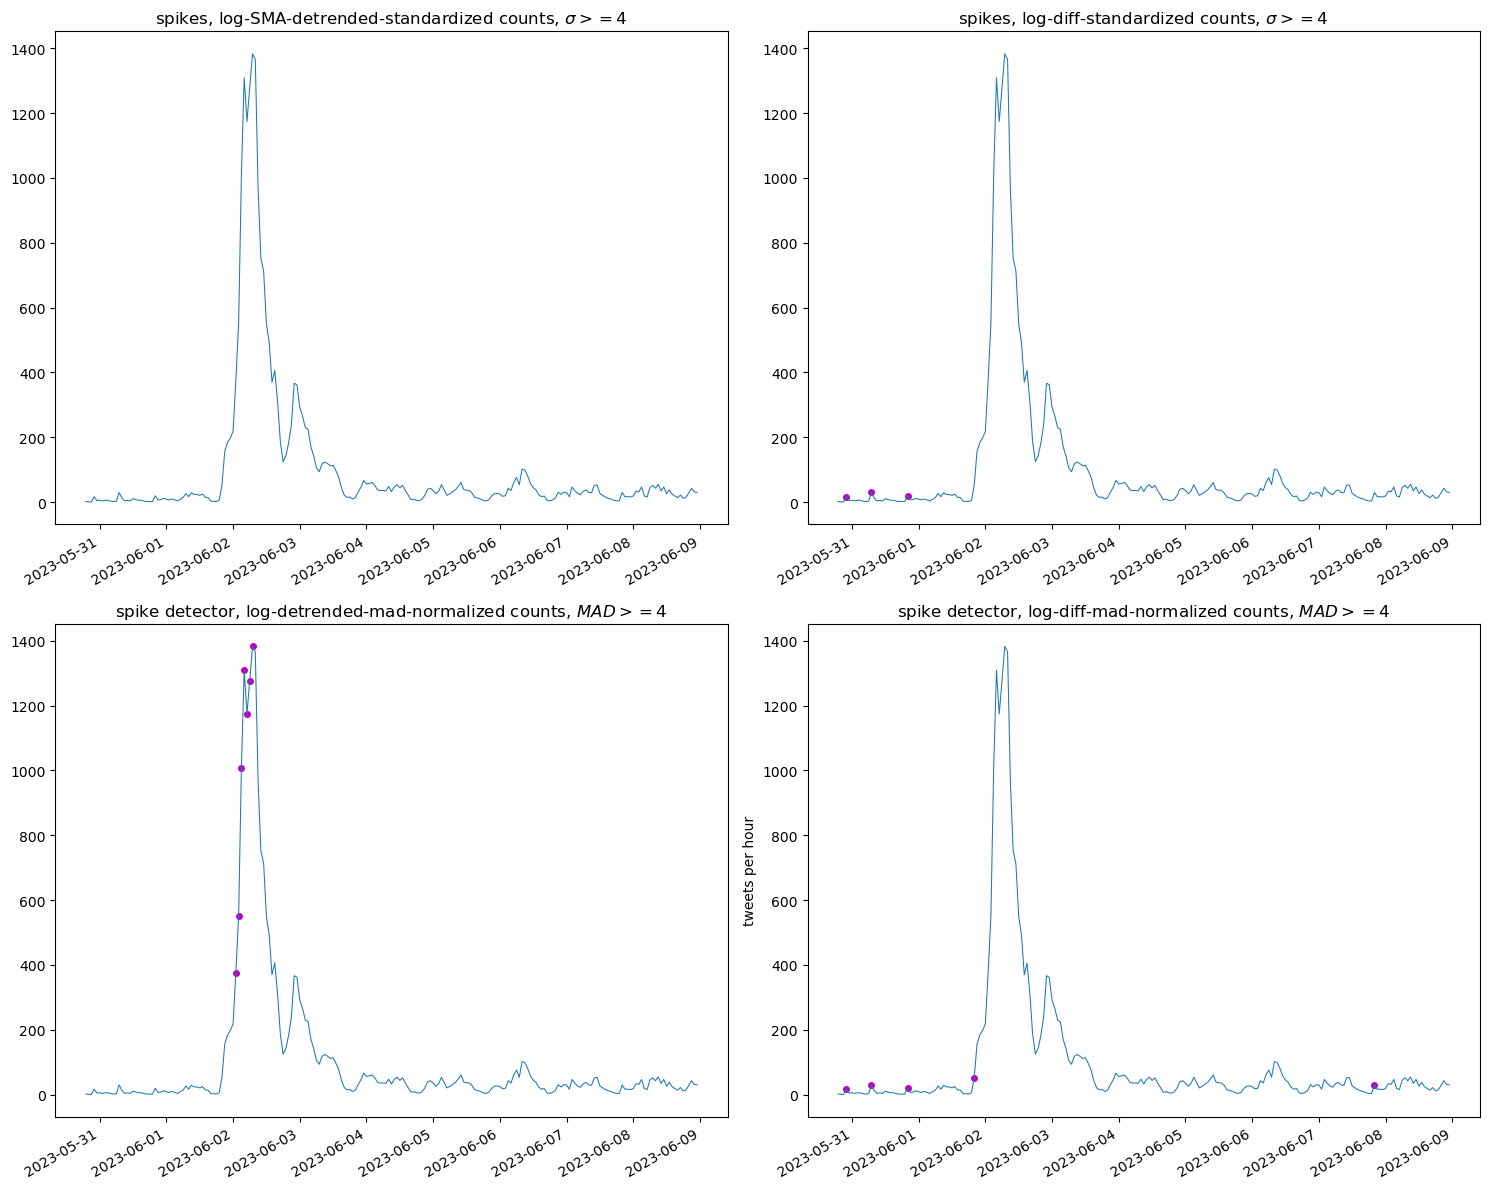

In [72]:
UNIT_THRESHOLD = 4
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15, 12))
[ax.xaxis.label.set_visible(False) for ax in axes.ravel()]

plot_ts(hourly_data,
        raw=True,
        title=f"spikes, log-SMA-detrended-standardized counts, $\sigma >={UNIT_THRESHOLD}$",
        custom_ax=axes[0][0],
        date_markers=(hourly_data
                      .pipe(np.log)
                      .pipe(detrender)
                      .dropna()
                      .pipe(standardize)
                      .query("count >= @UNIT_THRESHOLD")
                      .index));

plot_ts(hourly_data,
        raw=True,
        title=f"spikes, log-diff-standardized counts, $\sigma >={UNIT_THRESHOLD}$",
        custom_ax=axes[0][1],
        date_markers=(hourly_data
                      .pipe(np.log)
                      .diff()
                      .pipe(standardize)
                      .query("count >= @UNIT_THRESHOLD")
                      .index));

plot_ts(hourly_data,
        raw=True,
        title=f"spike detector, log-detrended-mad-normalized counts, $MAD >={UNIT_THRESHOLD}$",
        custom_ax=axes[1][0],
        date_markers=(hourly_data
                      .pipe(np.log)
                      .pipe(detrender, method=np.median)
                      .dropna()
                      .pipe(mad_normalize)
                      .query("count >= @UNIT_THRESHOLD")
                      .index));

plot_ts(hourly_data,
        raw=True,
        title=f"spike detector, log-diff-mad-normalized counts, $MAD>={UNIT_THRESHOLD}$",
        custom_ax=axes[1][1],
        date_markers=(hourly_data
                      .pipe(np.log)
                      .diff()
                      .dropna()
                      .pipe(mad_normalize)
                      .query("count >= @UNIT_THRESHOLD")
                      .index));